## Preparar el entorno

In [1]:
!pip install -r requirements.txt
!pip install utils.py

In [2]:
import random
import pickle
from utils import *
from joblib import dump, load
from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score, precision_score, recall_score # Reporte
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.models import load_model

## Cargar los datos

In [3]:
# Cargar Parquet
data = pd.read_parquet('processed_data.parquet')

Verificamos si hay valores 'NaN' en el conjunto de datos antes de dividirlo en train y test:

In [5]:
print(data.isnull().sum())

rating                          0
title                           0
text                            0
images                          0
asin                            0
parent_asin                     0
user_id                         0
timestamp                       0
helpful_vote                    0
verified_purchase               0
sentiment                       0
cleaned_text                    0
cleaned_text_exclude_numbers    0
text_length                     0
dtype: int64


In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   rating                        50000 non-null  float64
 1   title                         50000 non-null  object 
 2   text                          50000 non-null  object 
 3   images                        50000 non-null  object 
 4   asin                          50000 non-null  object 
 5   parent_asin                   50000 non-null  object 
 6   user_id                       50000 non-null  object 
 7   timestamp                     50000 non-null  int64  
 8   helpful_vote                  50000 non-null  int64  
 9   verified_purchase             50000 non-null  bool   
 10  sentiment                     50000 non-null  object 
 11  cleaned_text                  50000 non-null  object 
 12  cleaned_text_exclude_numbers  50000 non-null  object 
 13  t

## Verificar el preprocesamiento de los datos

In [7]:
# Seleccionamos al azar 5 muestras para comparar el texto original con el preprocesado
samples = random.sample(range(len(data)), 5)

# Imprimimos el texto original y el texto preprocesado para cada muestra seleccionada
for i in samples:
    original_text = data.loc[i, 'text']
    cleaned_text = data.loc[i, 'cleaned_text']
    cleaned_text_exclude_numbers = data.loc[i, 'cleaned_text_exclude_numbers']

    print(f"Muestra {i}:")
    print("Texto Original:")
    print(original_text)
    print("\nTexto Limpiado:")
    print(cleaned_text)
    print("\nTexto Limpiado Excluyendo Números:")
    print(cleaned_text_exclude_numbers)
    print("-" * 100)

Muestra 41165:
Texto Original:
Super great blanket... Took it Maui, and it fit in the suitcase perfectly.  Enough room for me and my honey to chill on the beach on, and easy to pack up and move.

Texto Limpiado:
super great blanket took maui fit suitcase perfectly enough room honey chill beach easy pack move

Texto Limpiado Excluyendo Números:
super great blanket took maui fit suitcase perfectly enough room honey chill beach easy pack move
----------------------------------------------------------------------------------------------------
Muestra 7352:
Texto Original:
The moon on the flag is facing the wrong way.

Texto Limpiado:
moon flag facing wrong way

Texto Limpiado Excluyendo Números:
moon flag facing wrong way
----------------------------------------------------------------------------------------------------
Muestra 3253:
Texto Original:
[[VIDEOID:d316b2dbc61122bf2296492ba0a66ffc]] Okay so I'm a few hours out of the box and needed to start my review now..I'll be updating this 

### Observaciones

- **Eliminación de Ruido:** Se ha eliminado el ruido como símbolos especiales, números (en el texto "excluyendo números"), y URLs y etiquetas HTML.

- **Normalización:** El texto se ha convertido a minúsculas, lo que ayuda a unificar variantes de la misma palabra y reduce la complejidad del modelo.

- **Reducción de Texto:** Los textos limpios son más cortos que los originales. Esto indica que se ha eliminado información no esencial, pero es importante asegurarse de que este proceso no descarte detalles que podrían ser relevantes para determinar el sentimiento.

- **Mantenimiento del Contexto:** A pesar de la reducción, se ha mantenido el contexto esencial necesario para entender el sentimiento general del texto.

- La presencia de la cadena `"videoidd316b2dbc61122bf2296492ba0a66ffc"` en el texto limpiado del ejemplo 4 puede señalar varios puntos importantes a considerar en el contexto del análisis de sentimientos y el preprocesamiento de textos:

  1. **Irrelevancia para el Análisis de Sentimientos**: Este tipo de cadena parece ser un identificador único, posiblemente relacionado con un video. En el contexto del análisis de sentimientos, este tipo de información no aporta valor porque no contribuye a entender el sentimiento del texto. Por lo tanto, su presencia podría ser considerada ruido en los datos.

  2. **Consistencia en el Preprocesamiento**: La inclusión de este identificador sugiere que el preprocesamiento podría no estar eliminando consistentemente todos los tipos de ruido no textual que no contribuyen al análisis semántico o sentimental del texto.

  3. **Potencial para Sesgo o Ruido en el Modelo**: Dejar cadenas de identificadores como esta en el texto que se va a analizar puede introducir ruido en el modelo, ya que el modelo podría aprender a asociar estos identificadores con ciertos sentimientos de manera injustificada.

  4. **Impacto en la Vectorización**: En el contexto de la vectorización mediante el modelo de bolsa de palabras, cada token único se considera una característica. Tokens irrelevantes como estos identificadores ocuparán espacio en el vector de características sin aportar valor predictivo, reduciendo potencialmente la eficacia del modelo.

<br>

### Conclusión

Aunque la presencia de este identificador no es crítica, sería beneficioso refinar la estrategia de preprocesamiento para garantizar datos relevantes y limpios.

Se decide **excluir los números** en el entrenamiento del modelo de análisis de sentimientos para **reducir el ruido y simplificar la estructura de los datos**, permitiendo al modelo enfocarse en el lenguaje significativo que influye en el sentimiento. Al eliminar los números, se espera mejorar la claridad de las señales semánticas para optimizar el rendimiento en la clasificación binaria.

# 1. Preparación de los datos

## Definir variable objetivo

Primero clasificamos las reviews en categorías como positivo/negativo. Para ello consideramos las reseñas con una calificación de 4 o 5 más como positivas (`1`) y las demás como negativas (`0`). Añadimos una columna al DataFrame para representar esta clasificación:

In [9]:
# Imprimir los valores únicos de 'sentiment'
print(data['sentiment'].unique())

['negativa' 'positiva']


In [4]:
# Codificar los valores de 'sentiment' como 0 para 'negativa' y 1 para 'positiva'
data['sentiment'] = data['sentiment'].map({'negativa': 0, 'positiva': 1})

In [11]:
data[['title','sentiment','rating']].head(10)

,title,sentiment,rating
0,Team emblem was affixed upside down...,0,1.0
1,Hardest to use...,0,1.0
2,Broke immediately can't be used,0,1.0
3,Black is cracking and falling off after 2 days...,0,1.0
4,Disappointed,0,1.0
5,My daughter wanted but doesn’t fit,0,1.0
6,Now it doesn't work at all... I am returning t...,0,1.0
7,"awful boot, awful frame = awful skate",0,1.0
8,Didn’t last a day,0,1.0
9,Garbage... don't buy it.,0,1.0


## División del Conjunto de Datos

Estratificamos por la columna de sentimiento para mantener la proporción de clases en ambos conjuntos.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text_exclude_numbers'],
    data['sentiment'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    stratify=data['sentiment']
)

In [13]:
X_train.iloc[:10]

30421    ankle sock super comfortable even though super...
15053    decent floor pump marred terrible chuck normal...
2858     update searched original review air mattress o...
43643                                      better expected
48661    good underwater fazed heavy rain either farm g...
37286                                  would better larger
10510    bought scooter son previously using much le ex...
19073    replaces year old fitbit charge lost ability d...
26408    cover fit well impede fitbit button color rubb...
24195    ordered prime bbq party tomorrow inside packag...
Name: cleaned_text_exclude_numbers, dtype: object

In [14]:
y_train.iloc[:10]

30421    1
15053    0
2858     0
43643    1
48661    1
37286    1
10510    0
19073    0
26408    0
24195    0
Name: sentiment, dtype: int64

## Vectorización de Textos

Tras considerar `CountVectorizer` y `TfidfVecgtorizer`, se decide utilizar [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) para la vectorización de las reseñas. Esta elección se basa en la capacidad de `TfidfVectorizer` para ponderar términos importantes que son únicos para reseñas específicas, su eficacia en tratar con documentos de longitud variable, y su habilidad para destacar palabras clave técnicas relevantes en el contexto de los productos de deporte y aire libre. Estos factores son importantes para este análisis, ya que se busca capturar la esencia y las peculiaridades de cada reseña de manera precisa.

### TF-IDF (Frecuencia de Término - Frecuencia Inversa de Documento)

Nos permite mejorar la relevancia de las características al ponderar las palabras en función de su importancia en el documento y en todo el corpus. TF-IDF aumenta el peso de los términos que son particularmente característicos de un documentos, mientras que disminuye el peso de los términos que aparecen en muchos documentos, considerándolos menos informativos o relevantes.

In [6]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=5000, ngram_range=(1,2))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

Hemos usado `TfidfVectorizer` para transformar los textos limpios a una representación numérica que pueda ser utilizada por los modelos de machine learning. Este paso convierte la colección de documentos de texto en matrices de características numéricas.


**Justificación de los parámetros del vectorizador:**

- `max_df=0.95`: Excluye términos que aparecen en más del 95% de los documentos, ya que es probable que no aporten información útil para diferenciar entre clases.
- `min_df=2`: Elimina términos que aparecen en menos de dos documentos, que podrían ser errores de tipeo o irrelevantes para la clasificación.
- `max_features=5000`: Limita las características a las 5,000 más importantes, lo que ayuda a controlar la dimensionalidad y mejora la eficiencia computacional.
- `ngram_range=(1,2)`: Consideramos unigramas y bigramas para capturar no solo palabras individuales sino también frases de dos palabras que podrían tener significado en el análisis de sentimientos.

In [16]:
print(list(vectorizer.vocabulary_.items())[:20])

[('ankle', 146), ('sock', 3933), ('super', 4177), ('comfortable', 762), ('even', 1256), ('though', 4341), ('soft', 3936), ('also', 113), ('thin', 4318), ('subtle', 4157), ('compression', 798), ('control', 842), ('built', 505), ('like', 2334), ('much', 2718), ('cotton', 862), ('spandex', 3980), ('supposedly', 4191), ('odor', 2868), ('take', 4239)]


In [17]:
vocab_df = pd.DataFrame(list(vectorizer.vocabulary_.items())[:20], columns=['Token', 'Índice'])
print(vocab_df)

          Token  Índice
0         ankle     146
1          sock    3933
2         super    4177
3   comfortable     762
4          even    1256
5        though    4341
6          soft    3936
7          also     113
8          thin    4318
9        subtle    4157
10  compression     798
11      control     842
12        built     505
13         like    2334
14         much    2718
15       cotton     862
16      spandex    3980
17   supposedly    4191
18         odor    2868
19         take    4239


Palabras como "pleasantly", "surprised", "professional", e "impressed" pueden tener **connotaciones positivas**, mientras que otras palabras son neutrales en términos de sentimiento. **Sin el contexto**, palabras como "grip", "play", o "away" pueden tener múltiples significados dependiendo de la oración en la que se encuentren. Esto destaca una **limitación de los modelos BoW**, donde la desambiguación del significado depende puramente de la distribución y co-ocurrencia de palabras, sin una comprensión real del lenguaje.

In [18]:
print(len(vectorizer.vocabulary_))

5000


In [19]:
# Verificamos los datos vectorizados
print("X_train_vect shape:", X_train_vect.shape)
print("X_test_vect shape:", X_test_vect.shape)

X_train_vect shape: (37500, 5000)
X_test_vect shape: (12500, 5000)


In [20]:
# Verificamos valores infinitos o faltantes
print("Infinitos en X_train_vect:", np.any(np.isinf(X_train_vect.data)))
print("NaNs en X_train_vect:", np.any(np.isnan(X_train_vect.data)))

Infinitos en X_train_vect: False
NaNs en X_train_vect: False


### Palabras con el TF-IDF en alguna review

#### Review de extensión corta

In [11]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 30663
Sentiment: 1
Review: husband looking size big pay attention measure bracelet


In [12]:
doc_vector = X_train_vect[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=vectorizer.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 30663:
                  tfidf
pay attention  0.458382
bracelet       0.442678
attention      0.377501
measure        0.358511
pay            0.301360
husband        0.275416
looking        0.246238
big            0.234340
size           0.201656

Top 10 words with lowest TF_IDF in the review 30663:
                  tfidf
pay attention  0.458382
bracelet       0.442678
attention      0.377501
measure        0.358511
pay            0.301360
husband        0.275416
looking        0.246238
big            0.234340
size           0.201656


La review en cuestión tiene menos de 20 palabras únicas, lo que significa que al solicitar los 10 términos con mayor y menor TF-IDF, inevitablemente se repetirán las mismas palabras, ya que no hay suficiente variedad en el texto para proporcionar listas distintas. Esto se debe a que el número de palabras únicas en el texto es menor que el número de términos que se intentan listar.

#### Review de extensión más larga

In [14]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 26276
Sentiment: 1
Review: always liked seethrough purse bag always see looking quick glance hardware good quality strap could stronger sufficient price store lot put everything extra pocket nice product


In [15]:
doc_vector = X_train_vect[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=vectorizer.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 26276:
                 tfidf
always        0.367972
nice product  0.304830
sufficient    0.273731
purse         0.263055
stronger      0.261304
hardware      0.245754
quick         0.209180
good quality  0.205175
liked         0.197063
store         0.191520

Top 10 words with lowest TF_IDF in the review 26276:
            tfidf
lot      0.150154
see      0.149130
bag      0.144873
price    0.142313
put      0.139240
could    0.133845
quality  0.131628
product  0.129083
nice     0.127650
good     0.107615


En la revisión más extensa, número `33004`, los términos con los valores TF-IDF más altos están directamente relacionados con la temática de yoga, como "yoga", "yoga mat", y "manduka". Esto sugiere que la review contiene detalles específicos sobre productos de yoga, lo que refleja un enfoque o una mención frecuente a estos elementos en el texto.

Los términos con los valores TF-IDF más bajos, como "room" y "went", probablemente sean de uso más común y aparecen en el contexto de la review sin destacar aspectos únicos de la experiencia del usuario, por lo que reciben un peso menor.

El contraste entre los términos más y menos destacados muestra cómo **TF-IDF diferencia entre palabras clave específicas y términos generales** en el análisis del contenido de la review.

### $\chi^2$ score

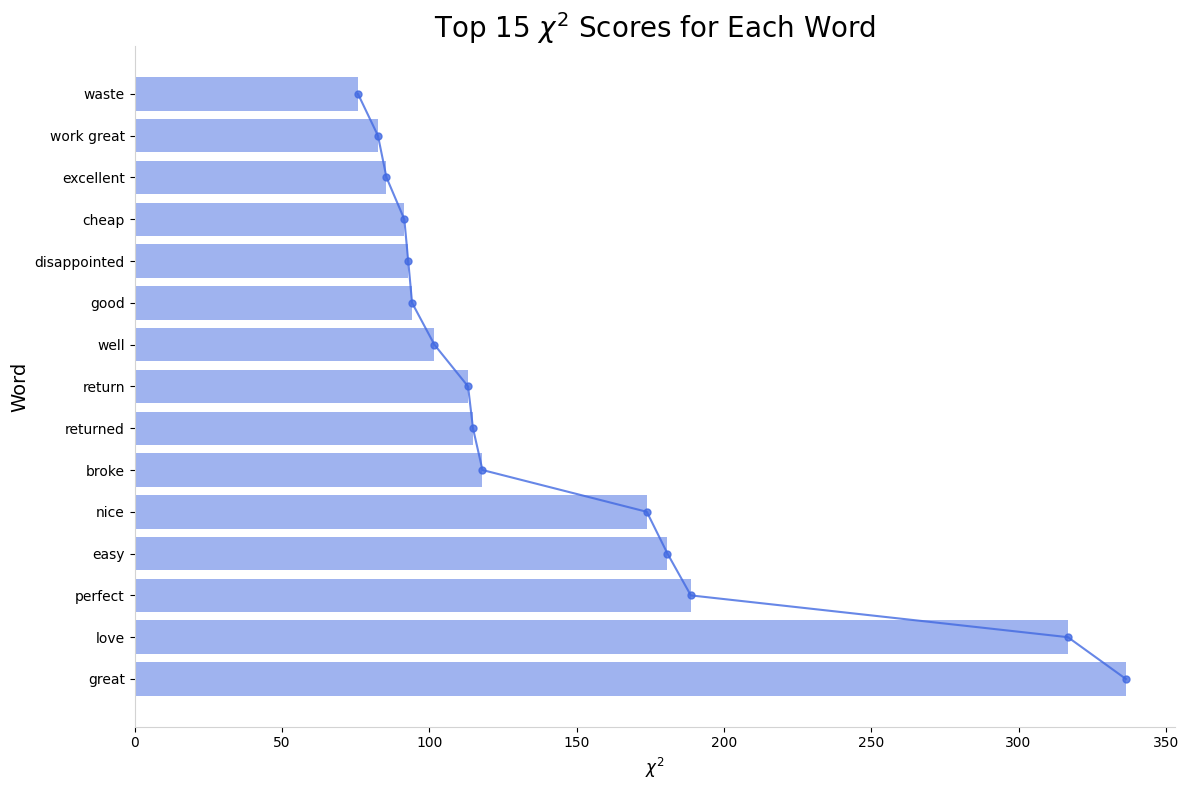

In [16]:
plot_chi2_scores(X_train_vect, y_train, vectorizer, top_features=15)

La gráfica muestra los **15 términos con las puntuaciones de Chi-cuadrado más altas**, lo que indica que son **estadísticamente significativos** en relación con la clasificación de los sentimientos de las reseñas.

Palabras como `great`, `love`, `perfect` y `excellent` tienen los valores *más altos*, sugiriendo una fuerte asociación con una de las clases (probablemente las reseñas **positivas**). En contraste, términos como `disappointed`, `cheap` y `waste` también presentan puntuaciones altas, lo que podría indicar una conexión con reseñas **negativas**.

Estas palabras clave ofrecen una visión de qué términos son predictores importantes en la evaluación del sentimiento de las reseñas y pueden ser útiles para mejorar los modelos de análisis de sentimientos y comprender mejor los aspectos que los clientes relacionan con experiencias positivas o negativas.

## Balanceo de Clases

In [22]:
print(f"Distribución de clases:\n{data['sentiment'].value_counts(normalize=True)}")

Distribución de clases:
0    0.6
1    0.4
Name: sentiment, dtype: float64


El **desbalance de clases** observado en los datos es un resultado directo del método utilizado para categorizar las reseñas de productos en positivas o negativas basándonos en la puntuación de estrellas; se consideran negativas las reseñas con puntuaciones de 1 a 3 estrellas, y positivas aquellas con 4 a 5 estrellas.

El desbalance de clases puede ser significativo ya que puede sesgar al modelo hacia la clase más frecuente, limitando su capacidad para identificar correctamente la clase menos representada. Para abordar este desbalance, se pueden aplicar estrategias como el sobremuestreo de la clase minoritaria, el submuestreo de la clase mayoritaria, o el uso de técnicas avanzadas como la generación de ejemplos sintéticos mediante algoritmos como SMOTE. También es importante utilizar métricas de evaluación que puedan dar una imagen más clara del rendimiento del modelo en todas las clases, como el F1-score, en lugar de confiar únicamente en la precisión.

# 2. Selección y Entrenamiento de Modelos

In [24]:
# Utilizamos esta función para extraer las características de Bag-of-Words
features_train, features_test, vocabulary = extract_BoW_features(X_train, X_test, max_features=5000, cache_file="bow_features.pkl")

Archivo de caché no encontrado. Extrayendo características. 
Escribir características en el archivo de caché: bow_features.pkl


En la función anterior, `TfidfVectorizer` es utilizado para extraer las características TF-IDF. Además, se implementa un sistema de caché que intenta leer las características precalculadas de un archivo, lo que puede ahorrar tiempo si ya has calculado estas características previamente. Si el archivo de caché no existe, calcula las características y luego las guarda en la caché para usos futuros.

In [25]:
print("Vocabulary: {} words".format(len(vocabulary)))

Vocabulary: 5000 words


In [26]:
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

print("\n--- Preprocessed words ---")
print(X_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(y_train[5])

Sample words: ['loses', 'drawstring', 'seven', 'emailed', 'shiny', 'min', 'tow', 'niece']

--- Preprocessed words ---
large little girl adult older teen

--- Bag-of-Words features ---
[0. 0. 0. ... 0. 0. 0.]

--- Label ---
0


El bloque de código anterior desempeña un papel clave en la inspección y el análisis de los datos procesados. Al **seleccionar aleatoriamente palabras del vocabulario aprendido**, nos ofrece una ventana a la diversidad y al tipo de términos que el modelo está considerando.

**Imprimir una muestra específica del texto preprocesado** junto con su correspondiente **vector de características Bag of Words y su etiqueta asociada** nos confirma que el preprocesamiento ha sido efectuado con éxito y que la representación numérica refleja fielmente el contenido del texto.

Además, al revisar las etiquetas, podemos garantizar la correcta alineación entre los datos y los resultados esperados del modelo. Esta metodología de verificación nos ayuda a comprender el mecanismo subyacente de nuestro proceso de vectorización y a asegurar la integridad y coherencia de nuestro flujo de trabajo de análisis de sentimientos, garantizando que cada paso, desde el muestreo del vocabulario hasta la asignación de etiquetas, se lleve a cabo como se planeó.

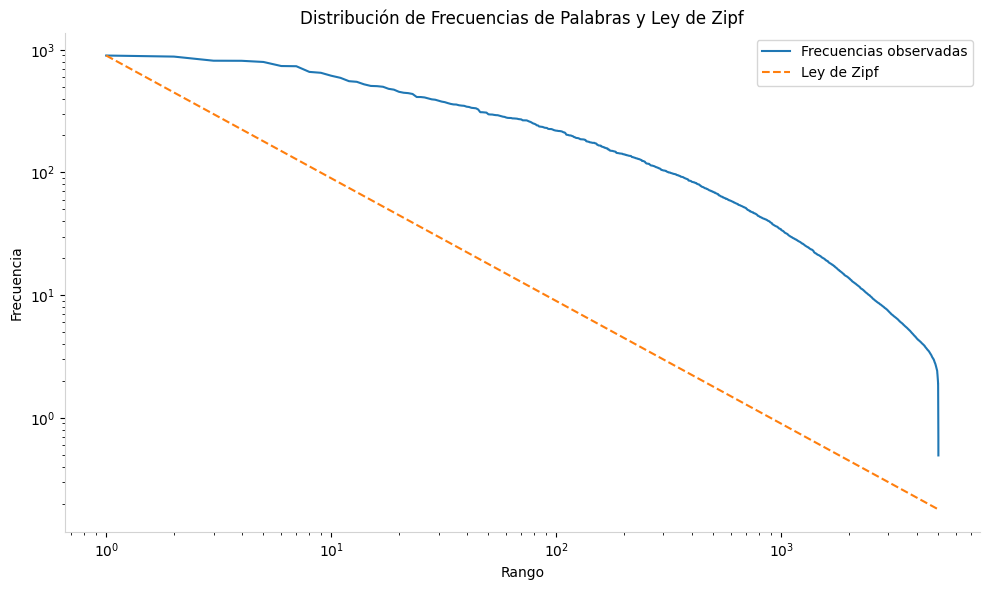

In [25]:
plot_zipf_law(features_train)

La gráfica muestra la **distribución de frecuencias de palabras** en los datos, junto con la **curva teórica de la Ley de Zipf** para comparar. La línea azul representa las frecuencias observadas, mientras que la línea naranja discontinua muestra la relación esperada de la Ley de Zipf.

La **Ley de Zipf** predice que la frecuencia de una palabra es inversamente proporcional a su rango en la lista de términos más frecuentes. En un gráfico log-log como este, el descenso inicial pronunciado y el posterior aplanamiento de la curva azul sugieren la presencia de algunas palabras extremadamente frecuentes seguidas por una larga cola de palabras menos comunes.

Este patrón es común en la distribución de palabras en idiomas naturales y textos reales, donde unas pocas palabras son muy frecuentes (como las palabras de parada y los términos genéricos), mientras que la mayoría aparece con poca frecuencia.

### Outliers

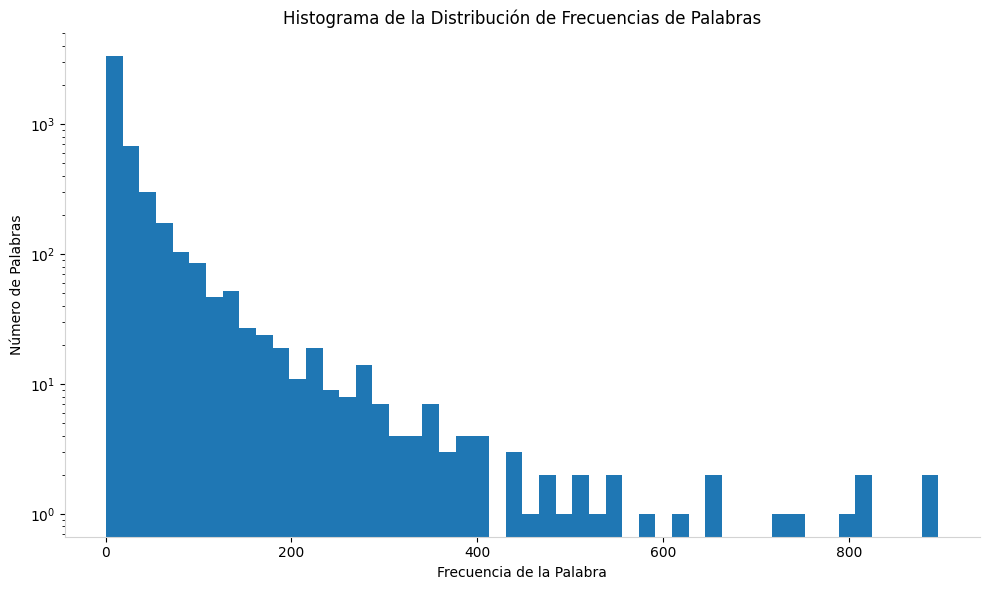

In [51]:
plot_word_frequency_distribution(features_train)

El histograma en escala logarítmica indica que una pequeña cantidad de palabras aparece con mucha frecuencia (el pico inicial alto), y la mayoría de las palabras aparece con baja frecuencia (la caída rápida y sostenida a lo largo del gráfico). Este patrón es típico en el lenguaje natural y concuerda con la Ley de Zipf, que sugiere que unas pocas palabras son extremadamente comunes mientras que muchas otras son raras.

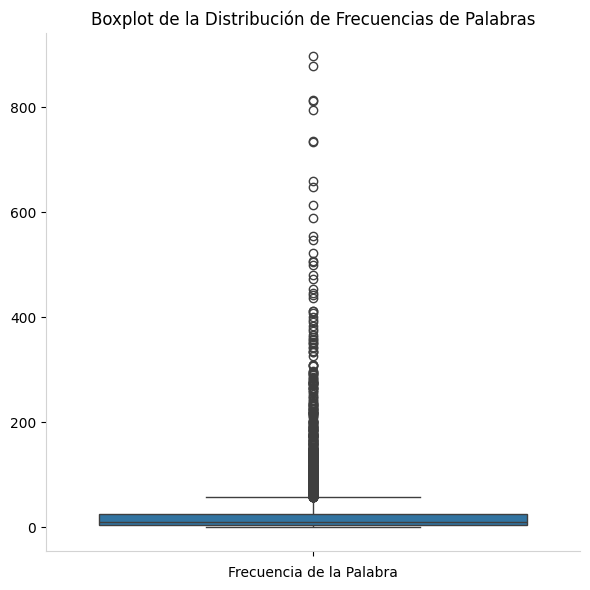

In [53]:
plot_word_frequency_boxplot(features_train)

El boxplot muestra que la mayoría de las palabras tienen frecuencias bajas (la caja es pequeña cerca del eje de frecuencia), con una línea larga que indica una variación considerable hacia las frecuencias más altas. Los círculos por encima del bigote superior representan los outliers, que son palabras con frecuencias significativamente más altas en comparación con el resto.

In [56]:
# Análisis de Outliers
q75, q25 = np.percentile(word_freq_distribution, [75 ,25])
iqr = q75 - q25

# Calcula el límite para considerar outliers
upper_whisker = q75 + (1.5 * iqr)

# Obtener las palabras que corresponden a estos outliers
vectorizer_feature_names = np.array(vectorizer.get_feature_names_out())
outlier_words = vectorizer_feature_names[word_counts > upper_whisker]

print(f"Outlier Words: {outlier_words}")

Outlier Words: ['absorb' 'acceptable' 'adjustable' 'adjustment' 'aerobic' 'afford' 'aid'
 'alarm' 'also come' 'also make' 'android' 'annoying' 'another brand'
 'anticipated' 'anything' 'anyway' 'apartment' 'appropriate' 'around edge'
 'around house' 'arrive' 'attaching' 'attempt' 'augason' 'automatic'
 'axle' 'backup' 'backyard' 'bank' 'bar' 'baseball' 'basic' 'battery'
 'battery life' 'bean bag' 'bearing' 'become' 'bed' 'best' 'better' 'bin'
 'bite valve' 'black one' 'block' 'blood' 'blowing' 'bolt' 'bonus'
 'bottle' 'bought product' 'bought use' 'bought year' 'bouncing'
 'brand new' 'break' 'break easily' 'bridge' 'bruise' 'buckle' 'bump'
 'busted' 'busy' 'california' 'cam' 'canopy' 'canteen' 'cap'
 'carry around' 'cat' 'cell phone' 'chain' 'chance' 'cheapest' 'cheaply'
 'checking' 'circulation' 'classic' 'clear' 'climbing' 'close' 'coated'
 'cold long' 'color great' 'comfy' 'commercial' 'compartment'
 'competitive' 'connect' 'constant' 'contains' 'contigo' 'continue use'
 'continued

### Consideraciones

Llegados a este punto podríamos:
- **Optimizar el preprocesado**: revisar las palabras más y menos frecuentes y detectar términos que no contribuyen al análisis o incluir más pasos como la corrección ortográfica.
- **Revisar las Stopwords**: asegurarnos de que todas las stopwords relevantes han sido excluidas. La lista de stopwords puede necesitar personalización para adaptarse al contexto específico del dominio de los datos.
- **Analizar y examinar los outliers**: investigar si son términos específicos del dominio relevantes o artefactos que deben ser tratados en el preprocesamiento.
- **Ajuste de Hiperparámetros** como `max_features, ngram_range`, y `min_df` o `max_df` para controlar la complejidad del modelo y la dimensionalidad de los datos.

## Entrenamiento

In [41]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=10000)
    lr.fit(X_train_vect, y_train)

    train_predict = lr.predict(X_train_vect)
    test_predict = lr.predict(X_test_vect)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.6812
Accuracy for C=0.05: 0.78856
Accuracy for C=0.25: 0.81832
Accuracy for C=0.5: 0.8232
Accuracy for C=1: 0.82856
Accuracy for C=10: 0.82296
Accuracy for C=100: 0.8076
Accuracy for C=1000: 0.8032
Accuracy for C=10000: 0.8032


In [66]:
# Espacio de búsqueda de hiperparámetros
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Realizamos la búsqueda con validación cruzada
grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5)
grid_search.fit(X_train_vect, y_train)

print('Best Parameters:', grid_search.best_params_)

Best Parameters: {'C': 1}


Los resultados nos dan una visión clara sobre cómo el parámetro de regularización C afecta el rendimiento del modelo de Regresión Logística.

El modelo con `C=1` parece tener el mejor equilibrio entre sesgo y varianza, con la precisión más alta en el conjunto de prueba.

La disminución de la precisión con valores de C mayores a 1 sugiere que el modelo empieza a memorizar el conjunto de entrenamiento en lugar de aprender las generalizaciones subyacentes.

Métricas:

In [42]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[6286 1214]
 [1246 3754]]

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      7500
           1       0.76      0.75      0.75      5000

    accuracy                           0.80     12500
   macro avg       0.80      0.79      0.79     12500
weighted avg       0.80      0.80      0.80     12500

Accuracy score:0.8032


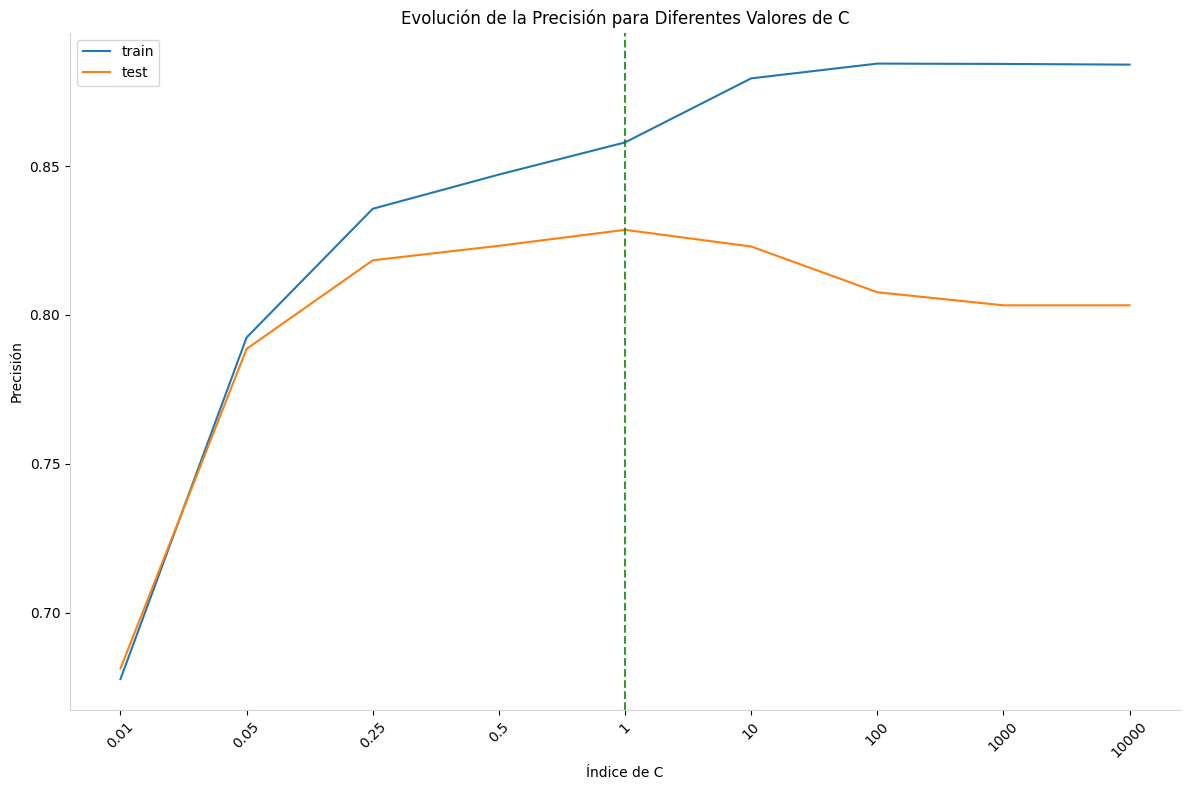

<Figure size 640x480 with 0 Axes>

In [68]:
plot_accuracy_evolution(c_params, train_acc, test_acc)

El **valor óptimo de C** (donde la línea discontinua cruza el eje x) parece ser **alrededor de 1**, ya que este punto maximiza la precisión del conjunto de prueba.

El gráfico es coherente con el principio de que mientras más complejo sea el modelo (menos regularización), mejor será en el conjunto de entrenamiento, pero solo hasta cierto punto antes de que comience a sobreajustarse y su rendimiento en los datos de prueba disminuya.

In [59]:
p, r, thresholds = precision_recall_curve(y_test, test_predict)

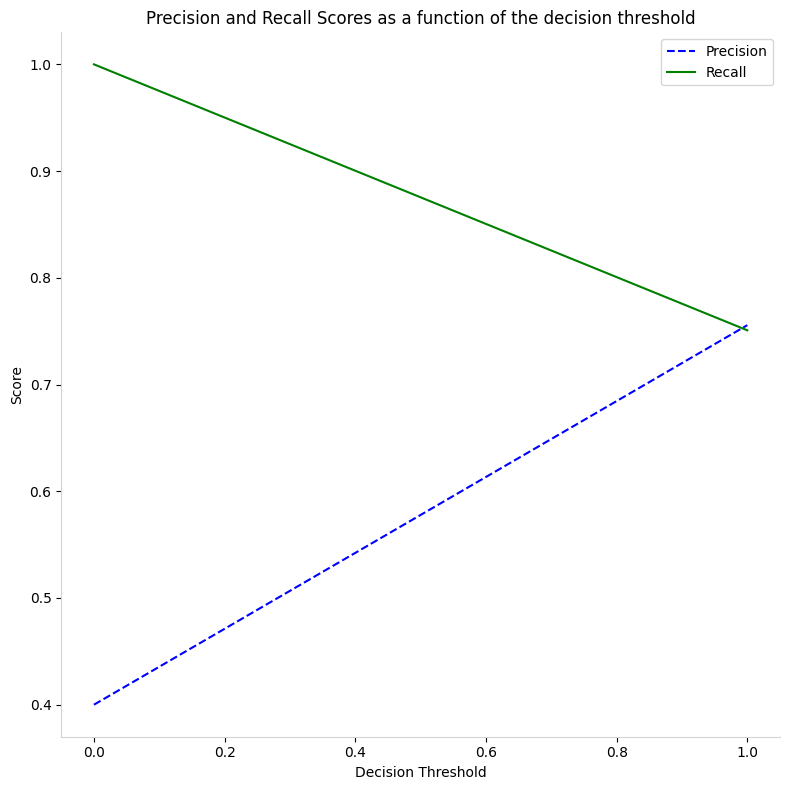

In [62]:
plot_precision_recall_vs_threshold(p, r, thresholds)

### Regresión Logística

In [65]:
# Inicializamos el modelo con el valor de regularización que parecía óptimo
log_reg = LogisticRegression(C=1, solver='lbfgs', max_iter=10000)

# Entrenamos el modelo
log_reg.fit(X_train_vect, y_train)

LogisticRegression(C=1, max_iter=10000)

In [27]:
# Realizamos predicciones en el conjunto de prueba
y_test_pred = log_reg.predict(X_test_vect)

# Calculamos las métricas de evaluación
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred))
print('\nClassification Report:\n', classification_report(y_test, y_test_pred))
print('Accuracy Score:', accuracy_score(y_test, y_test_pred))

Confusion Matrix:
 [[6612  888]
 [1255 3745]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      7500
           1       0.81      0.75      0.78      5000

    accuracy                           0.83     12500
   macro avg       0.82      0.82      0.82     12500
weighted avg       0.83      0.83      0.83     12500

Accuracy Score: 0.82856


In [66]:
# Probabilidades de la clase positiva
y_test_prob = log_reg.predict_proba(X_test_vect)[:, 1]

# Evaluamos la precisión, recall y la puntuación F1
print('Precision:', precision_score(y_test, y_test_pred))
print('Recall:', recall_score(y_test, y_test_pred))
print('F1 Score:', f1_score(y_test, y_test_pred))

# Evaluamos la puntuación ROC-AUC
print('ROC-AUC Score:', roc_auc_score(y_test, y_test_prob))

Precision: 0.8083315346427801
Recall: 0.749
F1 Score: 0.77753555486349
ROC-AUC Score: 0.90407908


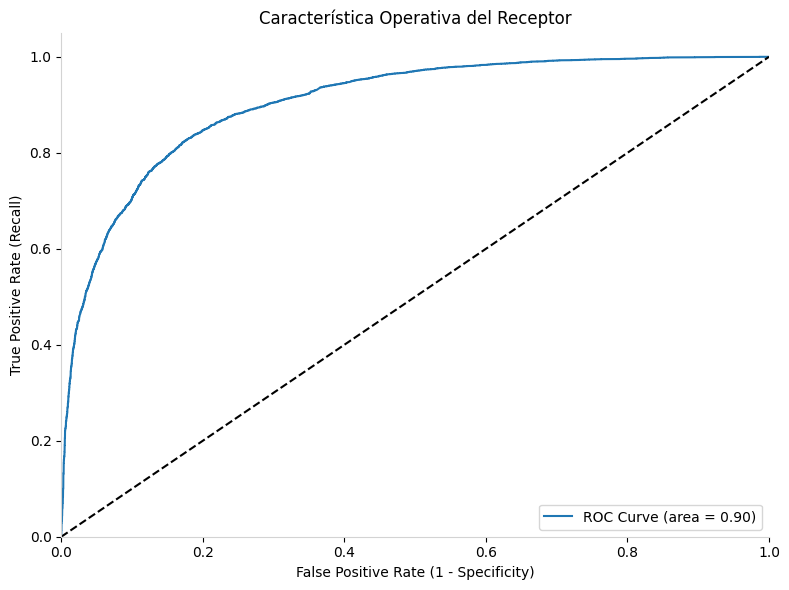

In [31]:
# Generamos la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Característica Operativa del Receptor')
plt.legend(loc='lower right')
style_plot()

### Regresión Logística con validación cruzada

In [67]:
cv_scores = cross_val_score(log_reg, X_train_vect, y_train, cv=5)

# Imprimimos los resultados de la validación cruzada
print('CV Accuracy Scores:', cv_scores)
print('CV Accuracy Mean:', cv_scores.mean())

CV Accuracy Scores: [0.82306667 0.8324     0.8196     0.83226667 0.82186667]
CV Accuracy Mean: 0.82584


In [68]:
# Guardamos el modelo entrenado en un archivo
model_filename = './logistic_regression.joblib'
dump(log_reg, model_filename)

['./logistic_regression.joblib']

In [69]:
# Carga el modelo
loaded_log_reg = load(model_filename)

# Podemos usar `loaded_log_reg` para hacer predicciones
y_pred = loaded_log_reg.predict(X_test_vect)

In [70]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.82856
Recall: 0.749
Precision: 0.8083315346427801
F1 Score: 0.77753555486349


### Gradient Boosting Classifier

In [69]:
# Configuración de los parámetros
n_estimators = 32
learning_rate = 1.0
max_depth = 1

# Función para entrenar y evaluar el modelo
def classify_gboost(X_train, X_test, y_train, y_test, n_estimators, learning_rate, max_depth):
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)

    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)

    print("[{}] Accuracy: train = {:.2f}%, test = {:.2f}%".format(
        clf.__class__.__name__,
        100 * train_accuracy,
        100 * test_accuracy
    ))

    return clf

# Entrenar y evaluar el clasificador de Gradient Boosting
clf_gboost = classify_gboost(X_train_vect, X_test_vect, y_train, y_test, n_estimators, learning_rate, max_depth)

[GradientBoostingClassifier] Accuracy: train = 75.70%, test = 75.66%


Utilizando validación cruzada y `RandomizedSearchCV`:

In [59]:
from sklearn.model_selection import RandomizedSearchCV

# Muestreo estratificado para mantener la proporción de clases (para agilizar la ejecución de la celda)
X_sample, _, y_sample, _ = train_test_split(X_train_vect, y_train, test_size=0.8, stratify=y_train, random_state=42)

# Definir el espacio de hiperparámetros para Gradient Boosting
param_grid_gboost = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [1, 3, 5]
}

# Inicializamos el modelo
gboost = GradientBoostingClassifier(random_state=42)

# Configuramos RandomizedSearchCV
random_search_gboost = RandomizedSearchCV(estimator=gboost, param_distributions=param_grid_gboost, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
random_search_gboost.fit(X_sample, y_sample) # Usamos X_sample y y_sample para la búsqueda de hiperparámetros

print("Mejores parámetros (Gradient Boosting):", random_search_gboost.best_params_)
print("Mejor puntuación (Gradient Boosting):", random_search_gboost.best_score_)

# Evaluar con el conjunto de prueba
best_gboost = random_search_gboost.best_estimator_
print("Precisión en conjunto de prueba (Gradient Boosting):", best_gboost.score(X_test_vect, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros (Gradient Boosting): {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
Mejor puntuación (Gradient Boosting): 0.7610666666666666
Precisión en conjunto de prueba (Gradient Boosting): 0.76656


In [84]:
# Guardamos el modelo entrenado en un archivo
dump(random_search_gboost, './gradient_booting.joblib')

['./gradient_booting.joblib']

In [85]:
# Carga el modelo
loaded_rsgb = load('./gradient_booting.joblib')

# Podemos usar `loaded_log_reg` para hacer predicciones
y_pred = loaded_rsgb.predict(X_test_vect)

In [86]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.76656
Recall: 0.6152
Precision: 0.7557739557739558
F1 Score: 0.6782800441014333


### Modelo de Deep Learning

Preparación de los datos:

In [32]:
# Tokenización
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding para asegurar que todas las secuencias tengan la misma longitud
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

Construcción del modelo:

In [33]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Entrenamiento del modelo:

In [34]:
model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test))

Epoch 1/10
1172/1172 [==============================] - 96s 77ms/step - loss: 0.4559 - accuracy: 0.7853 - val_loss: 0.4046 - val_accuracy: 0.8186
Epoch 2/10
1172/1172 [==============================] - 87s 75ms/step - loss: 0.3605 - accuracy: 0.8420 - val_loss: 0.4007 - val_accuracy: 0.8216
Epoch 3/10
1172/1172 [==============================] - 91s 78ms/step - loss: 0.3215 - accuracy: 0.8619 - val_loss: 0.4187 - val_accuracy: 0.8150
Epoch 4/10
1172/1172 [==============================] - 83s 71ms/step - loss: 0.2885 - accuracy: 0.8772 - val_loss: 0.4578 - val_accuracy: 0.8100
Epoch 5/10
1172/1172 [==============================] - 86s 74ms/step - loss: 0.2594 - accuracy: 0.8903 - val_loss: 0.4783 - val_accuracy: 0.8072
Epoch 6/10
1172/1172 [==============================] - 110s 94ms/step - loss: 0.2314 - accuracy: 0.9033 - val_loss: 0.5234 - val_accuracy: 0.7993
Epoch 7/10
1172/1172 [==============================] - 87s 74ms/step - loss: 0.2066 - accuracy: 0.9133 - val_loss: 0.6052 

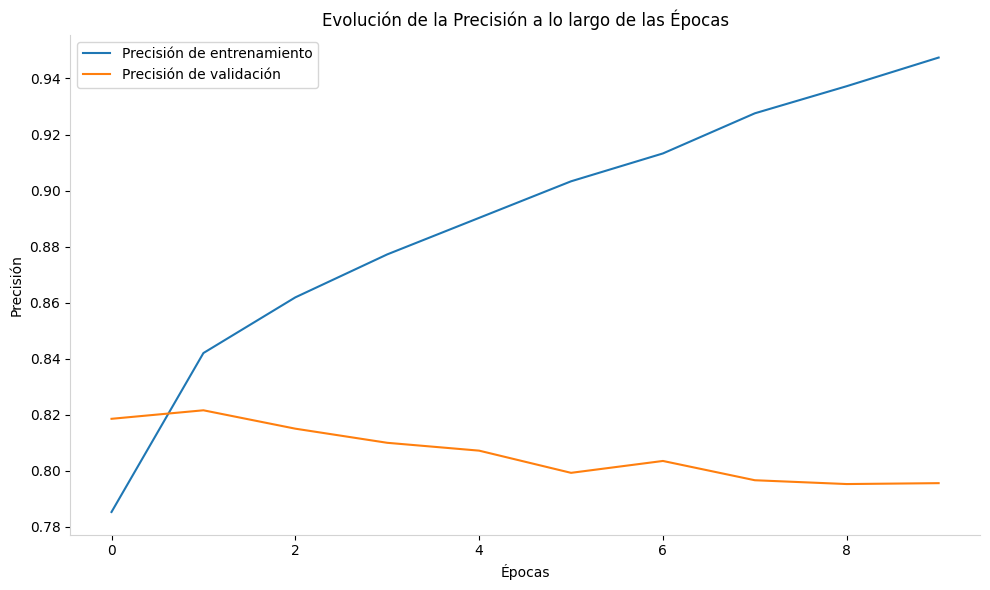

In [43]:
plot_training_history(model.history)

### 2º modelo de deep learning

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

model2 = Sequential()

# Añadimos SpatialDropout1D después de la capa Embedding para mejorar la regularización
model2.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
model2.add(SpatialDropout1D(0.2))

# Agregamos Dropout después de las capas LSTM
model2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

# Capa de salida
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Añadimos EarlyStopping para detener el entrenamiento cuando la pérdida de validación no mejore
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1172/1172 [==============================] - 201s 167ms/step - loss: 0.4453 - accuracy: 0.7903 - val_loss: 0.4003 - val_accuracy: 0.8245
Epoch 2/10
1172/1172 [==============================] - 194s 166ms/step - loss: 0.3631 - accuracy: 0.8427 - val_loss: 0.3923 - val_accuracy: 0.8235
Epoch 3/10
1172/1172 [==============================] - 195s 166ms/step - loss: 0.3295 - accuracy: 0.8580 - val_loss: 0.4143 - val_accuracy: 0.8143
Epoch 4/10
1172/1172 [==============================] - 196s 167ms/step - loss: 0.3052 - accuracy: 0.8695 - val_loss: 0.4214 - val_accuracy: 0.8166
Epoch 5/10
1172/1172 [==============================] - 197s 168ms/step - loss: 0.2811 - accuracy: 0.8818 - val_loss: 0.4510 - val_accuracy: 0.8073


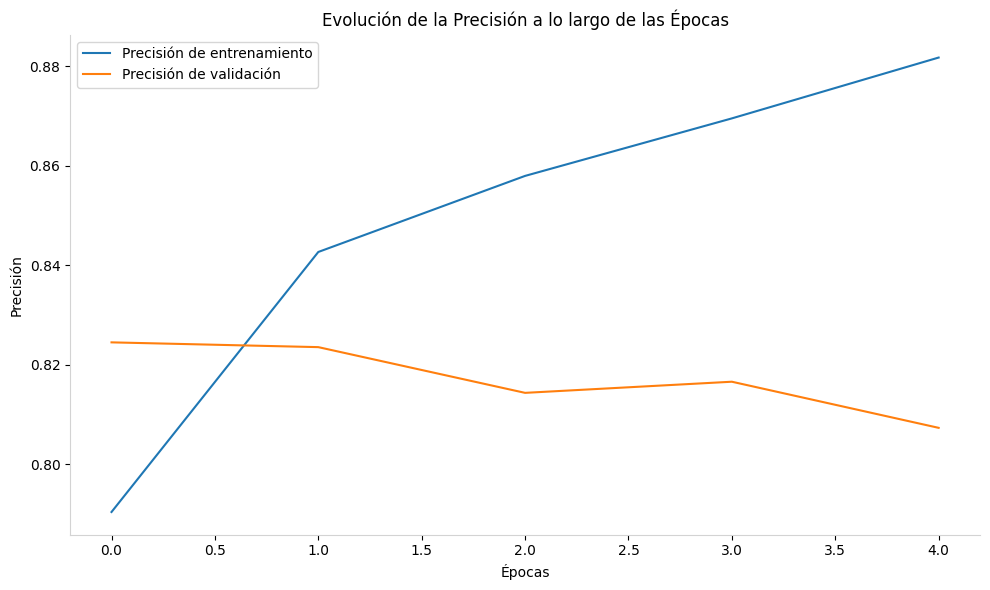

In [45]:
plot_training_history(history2)

# 3. Evaluación de Modelos

Evaluación del modelo de deep learning:

In [46]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Test Loss: {loss}')

391/391 [==============================] - 8s 22ms/step - loss: 0.8037 - accuracy: 0.7956
Accuracy: 79.56%
Test Loss: 0.8036667108535767


In [47]:
loss2, accuracy2 = model2.evaluate(X_test_pad, y_test)
print(f'Accuracy: {accuracy2*100:.2f}%')
print(f'Test Loss: {loss2}')

391/391 [==============================] - 10s 26ms/step - loss: 0.3923 - accuracy: 0.8235
Accuracy: 82.35%
Test Loss: 0.39227235317230225


In [81]:
# Obtener las probabilidades predichas
y_prob = model2.predict(X_test_pad)

# Convertir las probabilidades en etiquetas predichas
y_pred = (y_prob > 0.5).astype('int32')

391/391 [==============================] - 10s 24ms/step


In [82]:
# Calcular métricas
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)  # Usamos las probabilidades y no las etiquetas predichas

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC Score: {roc_auc:.4f}')

Precision: 0.7981
Recall: 0.7480
F1 Score: 0.7722
ROC-AUC Score: 0.8987


Guardar el modelo:

In [77]:
dump(model2, './lstm_model.joblib')

['./lstm_model.joblib']

Guardar el tokenizador:

In [52]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Para cargar el modelo posteriormente:

In [80]:
# Cargar el modelo
lstm_model = load('lstm_model.joblib')

In [ ]:
# Cargar el tokenizador
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

## Comparación de modelos

1. **Regresión Logística**:
   - **Accuracy**: 82.85%
   - **Precision**: 0.8083
   - **Recall**: 0.7490
   - **F1 Score**: 0.7775
   - **ROC-AUC**: 0.9041

2. **Gradient Boosting**:
   - **Accuracy**: 76.65%
   - **Precision**: 0.7557
   - **Recall**: 0.6152
   - **F1 Score**: 0.6782
   - **Mejor puntuación (CV)**: 0.7611
   - **Precisión en conjunto de prueba**: 0.7666

3. **Deep Learning (LSTM)**:
   - **Accuracy**: 82.35%
   - **Precision**: 0.7981
   - **Recall**: 0.7480
   - **F1 Score**: 0.7722
   - **ROC-AUC**: 0.8987

# Conclusiones

Los resultados demuestran que tanto los enfoques lineales como los modelos de deep learning avanzados tienen sus propias fortalezas, con la Regresión Logística y el modelo LSTM exhibiendo un desempeño similar y sólido. No obstante, es importante enfatizar que el desarrollo de modelos no termina en este punto:

**Optimización Continua:** A pesar del rendimiento prometedor, existe un potencial sin explotar en la afinación y optimización de hiperparámetros para cada modelo. Ajustes adicionales, particularmente para el Gradient Boosting y el modelo LSTM, podrían revelar mejoras significativas en precisión y otras métricas clave.

**Exploración de Preprocesado:** El impacto del preprocesado de texto en el rendimiento del modelo no debe subestimarse. Experimentar con diferentes estrategias de preprocesado, incluyendo la normalización avanzada de texto, el manejo de palabras clave y la ingeniería de características específicas del dominio, puede proporcionar ventajas sustanciales.

**Evaluación de Modelos Alternativos:** Además de los modelos examinados, explorar arquitecturas de deep learning más avanzadas o recientes podría ofrecer mejoras en el análisis de sentimientos, aprovechando, por ejemplo, modelos preentrenados o técnicas de aprendizaje por transferencia.

De forma resumida podríamos decir que los resultados actuales deben verse como un punto de partida. La selección del modelo ideal debería considerar no solo el rendimiento actual, sino también la flexibilidad para adaptarse a través de la optimización continua y la experimentación con preprocesado.